## Data Cleaning and Preparation
***

In [1]:
import pandas as pd
import numpy as np
import glob
import re
from bs4 import BeautifulSoup 
import requests
import pickle 
import matplotlib.pyplot as plt

In [2]:
# Load in T100 data from csv files

files_li = glob.glob('zippedData/T_T100D*.2.csv') 
bts_df = pd.DataFrame(pd.read_csv(files_li[0])) 
for i in range(1,len(files_li)): 
    data = pd.read_csv(files_li[i]) 
    df1 = pd.DataFrame(data) 
    bts_df = pd.concat([df1,bts_df],axis=0, ignore_index=True) 

In [3]:
# Keep only top 40 used aircraft models

bts_40 = bts_df['AIRCRAFT_TYPE'].value_counts().head(40).index.to_list()
indexNum = bts_df[~bts_df['AIRCRAFT_TYPE'].isin(bts_40)].index
bts_df.drop(indexNum , inplace=True)

In [4]:
# Get list of top 40 aircraft names for data cleaning

#bts_des = bts_df['AIRCRAFT_TYPE'].value_counts.to_frame()
bts_des = pd.DataFrame(pd.unique(bts_df['AIRCRAFT_TYPE']), columns =['AIRCRAFT_TYPE'])

In [5]:
# BTS uses number code to identify aircraft type in it's flight data. The legend is in a seperate csv file. 
# Load in the legend for aircraft type. 

ac_df = pd.read_csv('zippedData/L_AIRCRAFT_TYPE.csv')

In [6]:
# Merge flight data with aircfaft type. This will match BTS type names to the fligt data.

bts_des = pd.merge(bts_des,ac_df,left_on='AIRCRAFT_TYPE',right_on='Code')

In [7]:
# Drop piston aircraft
#bts_des = bts_des.drop(index=[5, 10, 18, 26, 29, 31, 37])
i = bts_des[(bts_des['Code'] == 40)].index
j = bts_des[(bts_des['Code'] == 35)].index
k = bts_des[(bts_des['Code'] == 194)].index
l = bts_des[(bts_des['Code'] == 79)].index
m = bts_des[(bts_des['Code'] == 479)].index
n = bts_des[(bts_des['Code'] == 415)].index
o = bts_des[(bts_des['Code'] == 416)].index
bts_des = bts_des.drop(i)
bts_des = bts_des.drop(j)
bts_des = bts_des.drop(k)
bts_des = bts_des.drop(l)
bts_des = bts_des.drop(m)
bts_des = bts_des.drop(n)
bts_des = bts_des.drop(o)


In [8]:
common_words = ['BOEING','CHEROKEE', 'AIRBUS', 'INDUSTRIE', 'CANADAIR', 'EMBRAER', 'MCDONNELL', 'DOUGLAS', 
                'DE', 'HAVILLAND', 'BEAVER', 'SUPER', 'NAVAJO', 'EM', 'ER', 'BEECH']

In [9]:
common_words_eng = ['ILYUSHIN', 'ANTONOV', 'JUNKERS', 'LOCKHEED', 'BOEING','AIRBUS', 'INDUSTRIE', 
                    'CANADAIR', 'EMBRAER', 'STATIONAIR','MCDONNELL', 'DOUGLAS', 'DE', 'HAVILLAND', 'BEAVER',
                    'SUPER','NAVAJO', 'EM', 'ER', 'BEECH', 'CRAFT', 'BOMBARDIER','CANADA']

In [10]:
common_words_emi = ['TRENT', 'CFMI', 'PRATT & WHITNEY', 'GENERAL ELECTRIC', 'CANADA',
                    'ROLLSROYCE', 'LYCOMING', 'ALLISON', 'GARRETT', 'CONTINENTAL', 'IAE']

In [11]:
def short_name(name, x):
    if len(name) >= x:
        short_name = name[:x]
        return(short_name)
    return(name)

In [12]:
def remove_dash(name):
    name = name.replace('-', '')
    return(name)

In [13]:
def convert_upper(name):
    name = name.upper()
    return(name)

In [14]:
def convert_date(date):
    date = date.astype('datetime64[ns]')
    return(date)

In [15]:
def remove_slash(name):
    res = re.match(r"^[^/]*", name)
    return(str(res.group())) 

In [16]:
def remove_common(name, common_w):
    for common in common_w:
        name = name.replace(common, '')
    return(name)

In [17]:
def remove_space(name):
    name = name.replace(' ', "")
    return(name)

In [18]:

def convert_boeing(name):
    if re.match(r"^(7)(.)(7)", name):
        name = name[:3]
    return name

In [19]:
def convert_crj(name):
    if re.match(r"^RJ", name):
        name = name.replace('RJ', 'CRJ')
    return name

In [20]:
bts_des.loc[bts_des['Code'] == 629, 'Description'] = 'Canadair RJ-200'
bts_des.loc[bts_des['Code'] == 631, 'Description'] = 'Canadair RJ-700'
bts_des.loc[bts_des['Code'] == 638, 'Description'] = 'Canadair RJ-900'
bts_des.loc[bts_des['Code'] == 838, 'Description'] = 'Boeing 737-800'
bts_des.loc[bts_des['Code'] == 674, 'Description'] = 'Embraer ERJ-130'
bts_des.loc[bts_des['Code'] == 676, 'Description'] = 'Embraer ERJ-140'
bts_des.loc[bts_des['Code'] == 675, 'Description'] = 'Embraer ERJ-145'
bts_des.loc[bts_des['Code'] == 677, 'Description'] = 'Embraer ERJ-170'
bts_des.loc[bts_des['Code'] == 678, 'Description'] = 'Embraer ERJ-190'

In [21]:
bts_des['Description'] = [convert_upper(x) for x in bts_des['Description']]
bts_des['Description'] = [remove_slash(x) for x in bts_des['Description']]
bts_des['Description'] = [remove_dash(x) for x in bts_des['Description']]
bts_des['Description'] = [remove_common(x, common_words) for x in bts_des['Description']]
bts_des['Description'] = [remove_space(x) for x in bts_des['Description']]
bts_des['Description'] = [short_name(x, 4) for x in bts_des['Description']]
bts_des['Description'] = [convert_boeing(x) for x in bts_des['Description']]
bts_des['Description'] = [convert_crj(x) for x in bts_des['Description']]

In [22]:
bts_df = pd.merge(bts_df,bts_des[['Code', 'Description']],left_on='AIRCRAFT_TYPE', right_on='Code')

In [23]:
bts_des.drop(['AIRCRAFT_TYPE', 'Code'], axis=1, inplace=True)

## Crash Data

In [24]:
# Import Data Set from CSV

crash_df = pd.read_csv('zippedData/AviationData.csv', encoding='latin-1', dtype={6: str, 7: str, 14: str, 15: str,
                                                                                 28: str})

In [27]:
# Drop rows before 2012 so we can match data by year in bts_df
date_mask = (crash_df['Event.Date'] > '2011-12-31')

# THIS RETURNS ALL ROWS GREATER THAN THE DATE PROVIDED ABOVE
crash_df = crash_df.loc[date_mask]

# Rows without an aircraft model type don't help use. Dropping these rows.
crash_df = crash_df.dropna(subset=['Model'])

In [28]:
# Some values in Make are upper, and some are mixed case. Change the Make column to all uppercase
#crash_df['Make'] = crash_df['Make'].str.upper()

# Convert Event.Date from string to datetime. Used to filter df on years
crash_df['Event.Date'] = crash_df['Event.Date'].astype('datetime64[ns]')

In [29]:
crash_df['Model'] = [convert_upper(x) for x in crash_df['Model']]
#crash_df['Event.Date'] = [convert_date(x) for x in crash_df['Event.Date']]
crash_df['Model'] = [remove_slash(x) for x in crash_df['Model']]
crash_df['Model'] = [remove_dash(x) for x in crash_df['Model']]
crash_df['Model'] = [remove_common(x, common_words) for x in crash_df['Model']]
crash_df['Model'] = [remove_space(x) for x in crash_df['Model']]
crash_df['Model'] = [short_name(x, 4) for x in crash_df['Model']]
crash_df['Model'] = [convert_boeing(x) for x in crash_df['Model']]
#crash_df['Model'].replace('PA-', 'PA', inplace=True, regex=True)

In [30]:
def match_types(model):
    for newmodel in bts_des['Description']:
        if newmodel.startswith(model):
            #print(f'Processing: {model} \t:{newmodel}')
            return newmodel

In [31]:
crash_df['NewModel'] = [match_types(model) for model in crash_df['Model']]

## Engine Data

In [32]:
# In place of running this and making lots of web requests, import the pickle file from below
# Assign URL |
#url = "https://asn.flightsafety.org/database/engines/"

# Make a GET request to fetch the raw HTML content 
#html_content = requests.get(url).text 

# Parse the response with html.parser
#soup = BeautifulSoup(html_content,"html.parser") 

# The data we need are wrapped in <a> tags. Grab all the <a> tags here and we'll filter later.
#datas = soup.find_all("a")


#Make list of URLs and list oF Aircraft to create dictionary
# k = []
# v = []
# for item in datas:
#     if 'engine' in item['href']:
#         k.append(item['href'])
#         v.append(item.text)

# lookup_dict = {'URL': k, 'Engine': v}


#url_df = pd.DataFrame.from_dict(lookup_dict)

# with open('lookup_dict.pkl', 'wb') as f:
#     pickle.dump(lookup_dict, f)

with open('zippedData/lookup_dict.pkl', 'rb') as f:
    lookup_dict = pickle.load(f)

In [33]:
# Take in the engine and retriev the matching data page with Aircraft data
# Add Aircraft list from web a python list.
# Return the python list

# url_p1 = 'https://asn.flightsafety.org'
# def lookup_ac(url_p2):
#     return_list = []
#     url = f'{url_p1}{url_p2}'
#     sub_content = requests.get(url).text
#     soup2 = BeautifulSoup(sub_content,"html.parser")
#     u_list=soup2.find_all('ul')[1]
#     i = 0 
#     while i < len(u_list.select('li')):
#         (u_list.select('li')[i].text)
#         return_list.append(u_list.select('li')[i].text)
#         i += 1
#     return(return_list)

# Create Aircraft column to list aircraft for each engine.
#url_df['Aircraft'] = url_df['URL'].map(lookup_ac)

# Save df to pickle file.
#url_df.to_pickle('zippedData/url_df.pkl')

with open('zippedData/url_df.pkl', 'rb') as f:
    url_df = pickle.load(f)

In [34]:
# Create a row for each aircraft for each engine. 
# Iterate through url_df['Aircraft'] column. For each element
# in list, create a new row.

engines = []
aircraft = []
for idx, row in url_df.iterrows():
    for ac in row['Aircraft']:
        engines.append(row['Engine'])
        aircraft.append(ac)

In [35]:
# Create dictionary from lists to load into dataFrame
ac_eng_dict = {'Engine': engines, 'Aircraft': aircraft}

In [36]:
# Create dataFrame from dictionary
engines_df = pd.DataFrame.from_dict(ac_eng_dict)

In [37]:
# df.loc[len(df.index)] = ['Amy', 89, 93] 
engines_df.loc[engines_df['Aircraft'] == 'Bombardier CRJ100 / 200 / 440'] = ['General Electric CF34','Canadair RJ-100']
engines_df.loc[engines_df['Aircraft'] == 'Bombardier CRJ700'] = ['General Electric CF34','Canadair RJ-700']
engines_df.loc[engines_df['Aircraft'] == 'Bombardier CRJ900'] = ['General Electric CF34','Canadair RJ-900']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Canadair RJ-200']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Canadair RJ-440']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-130']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-135']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-140']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-175']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-190']
engines_df.loc[len(engines_df.index)] = ['Pratt & Whitney JT8D', 'McDonnell Douglas DC-9-80']

In [38]:
engines_df['Aircraft'] = [convert_upper(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [remove_slash(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [remove_dash(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [remove_common(x, common_words_eng) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [remove_space(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [short_name(x, 4) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [convert_boeing(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [convert_crj(x) for x in engines_df['Aircraft']]

In [39]:
engines_df['Engine_Name'] = [convert_upper(x) for x in engines_df['Engine']]
engines_df['Engine_Name'] = [remove_slash(x) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [remove_dash(x) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [remove_common(x, common_words_emi) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [remove_common(x, common_words_emi) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [remove_space(x) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [short_name(x, 5) for x in engines_df['Engine_Name']]
#engines_df['Engine_Name'] = [convert_boeing(x) for x in engines_df['Engine_Name']]
#engines_df['Engine_Name'] = [convert_crj(x) for x in engines_df['Engine_Name']]

In [40]:
bts_des = pd.merge(bts_des, engines_df,left_on='Description', right_on='Aircraft', how='left')

In [41]:
bts_des.drop_duplicates(inplace=True)

## Emissions Data

In [42]:
emissions_df = pd.read_excel('zippedData/edb-emissions-databank_v30__web_.xlsx',
                             sheet_name='Gaseous Emissions and Smoke', 
                             usecols=('A:D, AJ'))

In [43]:
emissions_df['Engine Identification'] = [convert_upper(x) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [remove_slash(x) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [remove_dash(x) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [remove_common(x, common_words_emi) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [remove_space(x) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [short_name(x, 5) for x in emissions_df['Engine Identification']]

In [44]:
emissions_df.at[527,'Engine Identification'] = 'PW100'
emissions_df.at[611,'Engine Identification'] = 'PW200'
emissions_df.at[633,'Engine Identification'] = 'PW400'

In [45]:
def match_engine(str1):
    tmp_df = pd.DataFrame()
    mask = tmp_df['engine_id_starts_with_CFM'] = list( 
        map(lambda x: x.startswith(str1), emissions_df['Engine Identification'])) 
    filtered_df = emissions_df[mask]
    #return(filtered_df.at[0,1]['CO Dp/Foo Avg (g/kN)']).head(1)
    if filtered_df.shape[0] < 1:
        return(0)
    return(filtered_df.iat[0,4])

In [46]:
bts_des['CO2'] = [match_engine(x) for x in bts_des['Engine_Name']]

In [47]:
def get_best_eng(aircraft):
    ac_ser = bts_des.loc[bts_des['Aircraft'] == aircraft]
    return(ac_ser.sort_values('CO2')[:1])

## Data Processing

In [48]:
# Some rows have NaN for values. Replace these with 0 value. 
crash_df['Total.Fatal.Injuries'] = crash_df['Total.Fatal.Injuries'].fillna(0)
crash_df['Total.Serious.Injuries'] = crash_df['Total.Serious.Injuries'].fillna(0)
crash_df['Total.Minor.Injuries'] = crash_df['Total.Minor.Injuries'].fillna(0)

In [49]:
# Our scoring system will use 3 points for fatality; 1 point for serious injury and .5 points for minor injury.
crash_df['Injury_Score'] = crash_df['Total.Fatal.Injuries'].map(lambda x: x*3)
crash_df['Injury_Score'] = crash_df['Injury_Score'] + crash_df['Total.Serious.Injuries']
crash_df['Injury_Score'] = crash_df['Injury_Score'] + (crash_df['Total.Minor.Injuries'] * .5)

In [50]:
total_score = crash_df.groupby('NewModel')['Injury_Score'].sum().to_frame()

In [51]:
total_score['Count'] = bts_df.groupby('Description').size()

In [309]:
# We want to normalize the rating using Injury Score as reference metric.
max = crash_df['Injury_Score'].max()
min = crash_df['Injury_Score'].min()
score_range = max - min
#total_score['Rating'] = (total_score['Injury_Score'] / total_score['Count']) * 1000

In [310]:
score_range

885.0

In [53]:
total_score = pd.merge(total_score, bts_des[['CO2', 'Aircraft', 'Engine']], left_on='NewModel', right_on='Aircraft', how='left')

In [54]:
total_score.columns

Index(['Injury_Score', 'Count', 'Rating', 'CO2', 'Aircraft', 'Engine'], dtype='object')

In [55]:
final_score = total_score.sort_values(['CO2', 'Rating'], ascending=[True, True])

In [56]:
final_score[0:20]

,Injury_Score,Count,Rating,CO2,Aircraft,Engine
29,0.0,32440,0.000000,0.00,CASA,Garrett TPE331
30,0.0,32440,0.000000,0.00,CASA,General Electric CT7
0,29.0,44466,0.652184,0.00,1900,Pratt & Whitney Canada PT6
42,1.5,28799,0.052085,14.20,MD11,Pratt & Whitney PW4000
18,6.0,64824,0.092558,14.20,A300,Pratt & Whitney PW4000
14,106.5,98231,1.084179,14.20,767,Pratt & Whitney PW4000
8,40.0,24752,1.616031,14.20,747,Pratt & Whitney PW4000
20,24.5,213230,0.114899,14.80,A319,IAE V2500
43,2.5,21323,0.117244,14.80,MD90,IAE V2500
23,1504.5,332678,4.522391,14.80,A320,IAE V2500


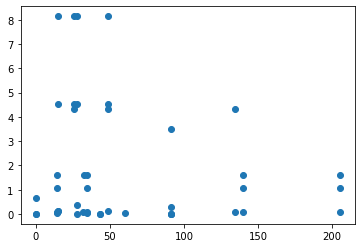

In [59]:
x_data = final_score['CO2']
y_data = final_score['Rating']
strings = final_score['Aircraft']

plt.scatter(x_data, y_data)
plt.show()

## Airport Data Analysis


In [289]:
# Load Airport and Population data from csv files
ap_df = pd.read_csv('zippedData/us-airports.csv')
cbsa_df = pd.read_csv('zippedData/cbsa-est2023-alldata.csv', encoding='latin-1')

In [290]:
# Only keep columns we need. Drop other columns
ap_df = ap_df[['id', 'ident', 'type', 'name', 'local_region', 'municipality','local_code',
               'iata_code', 'keywords']]
#ap_df = ap_df[(ap_df['type'] == 'medium_airport') | (ap_df['type'] == 'large_airport')]
ap_df = ap_df[(ap_df['type'] == 'large_airport')]

In [291]:
# Fileter rows to population > 550K 
cbsa_df = cbsa_df[['CBSA', 'MDIV', 'STCOU', 'NAME', 'LSAD','POPESTIMATE2022']]
cbsa_df.drop(cbsa_df[cbsa_df['POPESTIMATE2022'] <= 550000].index, inplace = True)


In [292]:
# Get count of flights originated at airport and convert to dict
ap_counts = bts_df['ORIGIN'].value_counts()
ap_counts_dict = ap_counts.to_dict()


In [293]:
# This takes in an airport code and returns the total number of flights orginating from there
def get_num_flt(code):
    try:
      val = ap_counts_dict[code]
    except:
      val = 0
    
    return val

In [294]:
# Function to take in City and State
# Match state and from list of State match city
# Return Population of City

def get_city_pop(city, state):
    cs_list = cbsa_df['NAME'].to_list()
    city_lst = []
    for cs in cs_list:
        if state == str(cs[-2:]):
            city_lst.append(cs)
            
    if len(city_lst) == 0:
        return(0)
    
    for name in city_lst:
        if city in name:
            return cbsa_df.loc[cbsa_df['NAME'] == name, 'POPESTIMATE2022'].values[0]
    return(0)

In [295]:
apuse_df = ap_df.copy()
apuse_df['NumFlights'] = [get_num_flt(x) for x in apuse_df['iata_code']]

ap_mask = (apuse_df['NumFlights'] != 0)
apuse_df = apuse_df.loc[ap_mask]


In [296]:
def get_state(str1):
    res = str1.split(',')
    return(res)
cbsa_df['STATE'] = [(get_state(x))[1].strip() for x in cbsa_df['NAME']]
cbsa_df['CITY'] = [(get_state(x))[0].split('-')[0] for x in cbsa_df['NAME']]


In [297]:
result2 = apuse_df.groupby(['municipality', 'local_region'])
#result2.get_group(('New York','NY'))

In [298]:
# extract keys from groups
keys = result2.groups.keys()

city_lst = []
state_lst = []
num_flt_lst = []

for i in keys:
    a_group = result2.get_group(i)
    city_lst.append(a_group['municipality'][:1].to_string(index=False))
    state_lst.append(a_group['local_region'][:1].to_string(index=False))
    num_flt_lst.append(a_group['NumFlights'].sum())
 

In [299]:
result2_dict = {'City': city_lst, 'State': state_lst, 'NumFlights': num_flt_lst}
result2_df = pd.DataFrame.from_dict(result2_dict)

In [300]:
result2_df

,City,State,NumFlights
0,Albuquerque,NM,12536
1,Anchorage,AK,22495
2,Atlanta,GA,108520
3,Austin,TX,27482
4,Baltimore,MD,36067
...,...,...,...
63,Tampa,FL,33187
64,Tulsa,OK,10089
65,Warwick,RI,8972
66,Washington,DC,37778


In [301]:
#result2_df['Population'] = [get_city_pop(x, y) for x in result2_df['City'] for y in result2_df['State']]
pop_lst = []
for i, x in result2_df.iterrows():
    
    rando.append(get_city_pop(x['City'], x['State']))
result2_df['Population'] = pop_lst

In [303]:
result2_df = result2_df.loc[result2_df['Population'] > 0]

In [304]:
#result2_df['PeopleFlight'] = [(x/y) for x in result2_df['Population'] for y in result2_df['NumFlights']]

In [306]:
pfr_lst = []
for i, x in result2_df.iterrows():
    
    ratio = x['Population']/x['NumFlights']
    pfr_lst.append(ratio)

In [307]:
result2_df['FPR'] = pfr_lst

<ipython-input-307-6c6b44b75cb6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result2_df['FPR'] = pfr_lst


In [308]:
result2_df.sort_values('FPR', ascending=False)

,City,State,NumFlights,Population,FPR
67,West Palm Beach,FL,11523,6139812,532.831034
36,Newark,NJ,55853,19563798,350.273002
57,Santa Ana,CA,9413,3150372,334.683098
41,Ontario,CA,16047,4669149,290.967097
38,Oakland,CA,20156,4578135,227.135096
27,Los Angeles,CA,64172,12870137,200.556894
30,Miami,FL,35830,6139812,171.359531
17,Fort Lauderdale,FL,36073,6139812,170.205195
51,Sacramento,CA,15095,2417259,160.136403
53,San Antonio,TX,20820,2655928,127.566186
